In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do problema
N = 100000  # Número de partículas
d = 0.6e-3  # Diâmetro das partículas (m)
e = 0.9  # Coeficiente de restituição
m = 0.001  # Massa das partículas (kg)
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura granular (K)
rho = 2000  # Densidade de partículas (partículas/m^3)

# Função para calcular a velocidade do som granular
def velocidade_do_som(T_g, m):
    return np.sqrt(k_B * T_g / m)

# Função para calcular a distribuição de Maxwell-Boltzmann
def distrib_maxwell_boltzmann(v, T_g, m):
    return (m / (2 * np.pi * k_B * T_g))**1.5 * np.exp(-m * v**2 / (2 * k_B * T_g))


In [ ]:
# Simulação das colisões
def simular_colisoes(N, T_g, m, e, timesteps):
    # Inicialização das velocidades
    v = np.random.normal(0, np.sqrt(k_B * T_g / m), N)

    for t in range(timesteps):
        # Selecionar pares de partículas para colisões
        pares = np.random.choice(N, (N // 2, 2))

        for (i, j) in pares:
            # Velocidades antes da colisão
            vi = v[i]
            vj = v[j]

            # Velocidades após a colisão
            v[i] = (vi + vj) / 2 + e * (vi - vj) / 2
            v[j] = (vi + vj) / 2 - e * (vi - vj) / 2

    return v

# Parâmetros da simulação
timesteps = 100

# Simulação
v = simular_colisoes(N, T_g, m, e, timesteps)


In [ ]:
# Cálculo das propriedades macroscópicas
def propriedades_macroscopicas(v, m):
    T_g_calc = np.mean(v**2) * m / k_B
    P = rho * T_g_calc * (1 + e**2)
    return T_g_calc, P

T_g_calc, P = propriedades_macroscopicas(v, m)

# Geração de gráficos
v_bins = np.linspace(np.min(v), np.max(v), 100)
pdf_v = distrib_maxwell_boltzmann(v_bins, T_g, m)

plt.figure(figsize=(12, 6))

# Distribuição de velocidades
plt.subplot(1, 2, 1)
plt.hist(v, bins=100, density=True, alpha=0.6, color='g')
plt.plot(v_bins, pdf_v, 'k-', lw=2)
plt.title('Distribuição de Velocidades')
plt.xlabel('Velocidade (m/s)')
plt.ylabel('Densidade de Probabilidade')

# Correlação entre velocidade e temperatura
plt.subplot(1, 2, 2)
plt.scatter(v, v**2 * m / k_B, alpha=0.5, color='b')
plt.title('Correlação entre Velocidade e Temperatura')
plt.xlabel('Velocidade (m/s)')
plt.ylabel('Temperatura Granular (K)')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros da simulação
N = 100  # Número de partículas
d = 0.6e-3  # Diâmetro das partículas (m)
e = 0.9  # Coeficiente de restituição
m = 0.001  # Massa das partículas (kg)
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 10  # Velocidade inicial do fluxo (m/s)
timesteps = 100  # Número de passos de tempo
dt = 1e-3  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)

# Inicialização das partículas
pos = np.random.rand(N, 2) * L  # Posições iniciais
vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + v_flux  # Velocidades iniciais

# Definição da cunha (avião)
cunha_pos = [L / 2, L / 2]
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)

def checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle):
    # Verificar colisão e atualizar velocidade
    x, y = pos.T
    x_cunha, y_cunha = cunha_pos
    normal = np.array([np.cos(cunha_angle), np.sin(cunha_angle)])
    rel_pos = pos - cunha_pos
    dist = np.dot(rel_pos, normal)
    colisao = dist < 0
    vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt):
    for t in range(timesteps):
        # Atualizar posições
        pos += vel * dt

        # Verificar colisões com a cunha
        vel = checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle)

        # Verificar colisões entre partículas (simplificação)
        for i in range(N):
            for j in range(i+1, N):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2

    return pos, vel

# Executar a simulação
pos, vel = simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt)

# Calcular propriedades macroscópicas
T_g_calc = np.mean(np.linalg.norm(vel, axis=1)**2) * m / k_B
rho = N / L**2
P = rho * T_g_calc * (1 + e**2)

# Geração de gráficos
v_bins = np.linspace(np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), 100)
pdf_v = (m / (2 * np.pi * k_B * T_g_calc))**1.5 * np.exp(-m * v_bins**2 / (2 * k_B * T_g_calc))

plt.figure(figsize=(12, 6))

# Distribuição de velocidades
plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(vel, axis=1), bins=100, density=True, alpha=0.6, color='g')
plt.plot(v_bins, pdf_v, 'k-', lw=2)
plt.title('Distribuição de Velocidades')
plt.xlabel('Velocidade (m/s)')
plt.ylabel('Densidade de Probabilidade')

# Correlação entre velocidade e temperatura
plt.subplot(1, 2, 2)
plt.scatter(np.linalg.norm(vel, axis=1), np.linalg.norm(vel, axis=1)**2 * m / k_B, alpha=0.5, color='b')
plt.title('Correlação entre Velocidade e Temperatura')
plt.xlabel('Velocidade (m/s)')
plt.ylabel('Temperatura Granular (K)')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros da simulação
N = 10000  # Número de partículas
d = 0.6e-3  # Diâmetro das partículas (m)
e = 0.9  # Coeficiente de restituição
m = 0.001  # Massa das partículas (kg)
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 10  # Velocidade inicial do fluxo (m/s)
timesteps = 100  # Número de passos de tempo
dt = 1e-3  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)

# Inicialização das partículas
pos = np.random.rand(N, 2) * L  # Posições iniciais
vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + v_flux  # Velocidades iniciais

# Definição da superfície triangular
tri_pos = np.array([[L/2, L], [L/4, 3*L/4], [3*L/4, 3*L/4]])  # Vértices do triângulo
tri_normal = np.array([[0, -1], [-np.sqrt(3)/2, 1/2], [np.sqrt(3)/2, 1/2]])  # Normais das superfícies

def checar_colisao_triangulo(pos, vel, tri_pos, tri_normal):
    for i, normal in enumerate(tri_normal):
        p1, p2 = tri_pos[i], tri_pos[(i+1) % 3]
        rel_pos = pos - p1
        edge_vec = p2 - p1
        edge_len = np.linalg.norm(edge_vec)
        edge_dir = edge_vec / edge_len
        dist_to_edge = np.dot(rel_pos, edge_dir)
        height = np.dot(rel_pos, normal)
        colisao = (height < 0) & (dist_to_edge > 0) & (dist_to_edge < edge_len)
        vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def simular(N, pos, vel, tri_pos, tri_normal, timesteps, dt):
    for t in range(timesteps):
        # Atualizar posições
        pos += vel * dt

        # Verificar colisões com a superfície triangular
        vel = checar_colisao_triangulo(pos, vel, tri_pos, tri_normal)

        # Verificar colisões entre partículas (simplificação)
        for i in range(N):
            for j in range(i+1, N):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2

    return pos, vel

# Executar a simulação
pos, vel = simular(N, pos, vel, tri_pos, tri_normal, timesteps, dt)

# Calcular propriedades macroscópicas
T_g_calc = np.mean(np.linalg.norm(vel, axis=1)**2) * m / k_B
rho = N / L**2
P = rho * T_g_calc * (1 + e**2)

# Geração de gráficos
v_bins = np.linspace(np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), 100)
pdf_v = (m / (2 * np.pi * k_B * T_g_calc))**1.5 * np.exp(-m * v_bins**2 / (2 * k_B * T_g_calc))

plt.figure(figsize=(12, 6))

# Distribuição de velocidades
plt.subplot(1, 2, 1)
plt.hist(np.linalg.norm(vel, axis=1), bins=100, density=True, alpha=0.6, color='g')
plt.plot(v_bins, pdf_v, 'k-', lw=2)
plt.title('Distribuição de Velocidades')
plt.xlabel('Velocidade (m/s)')
plt.ylabel('Densidade de Probabilidade')

# Correlação entre velocidade e temperatura
plt.subplot(1, 2, 2)
plt.scatter(np.linalg.norm(vel, axis=1), np.linalg.norm(vel, axis=1)**2 * m / k_B, alpha=0.5, color='b')
plt.title('Correlação entre Velocidade e Temperatura')
plt.xlabel('Velocidade (m/s)')
plt.ylabel('Temperatura Granular (K)')

plt.tight_layout()
plt.show()


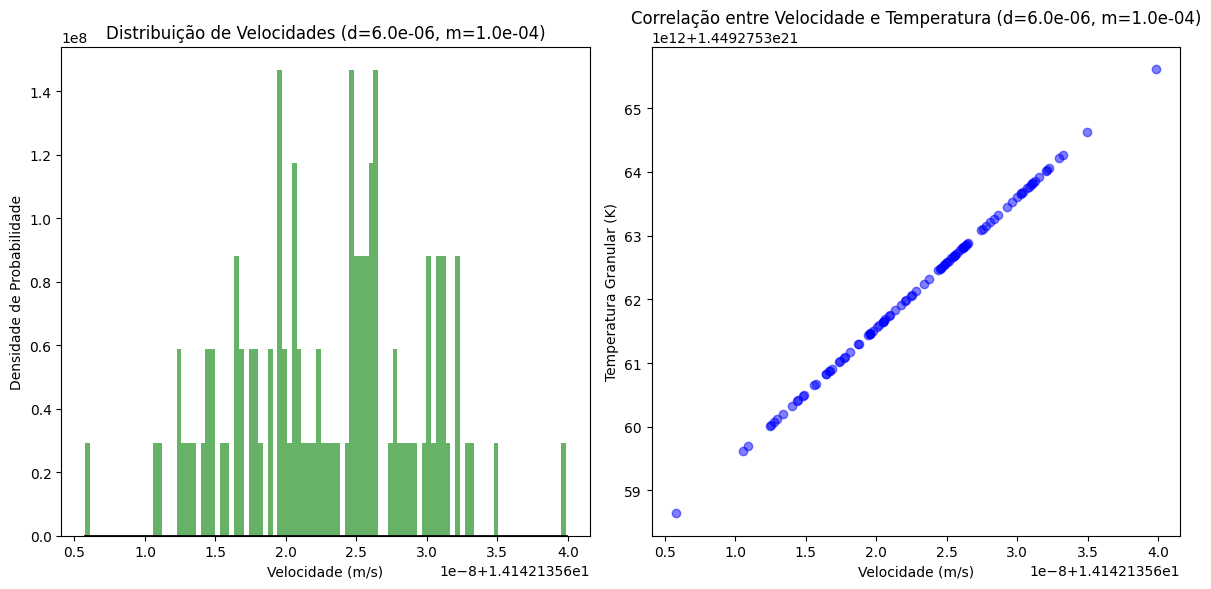

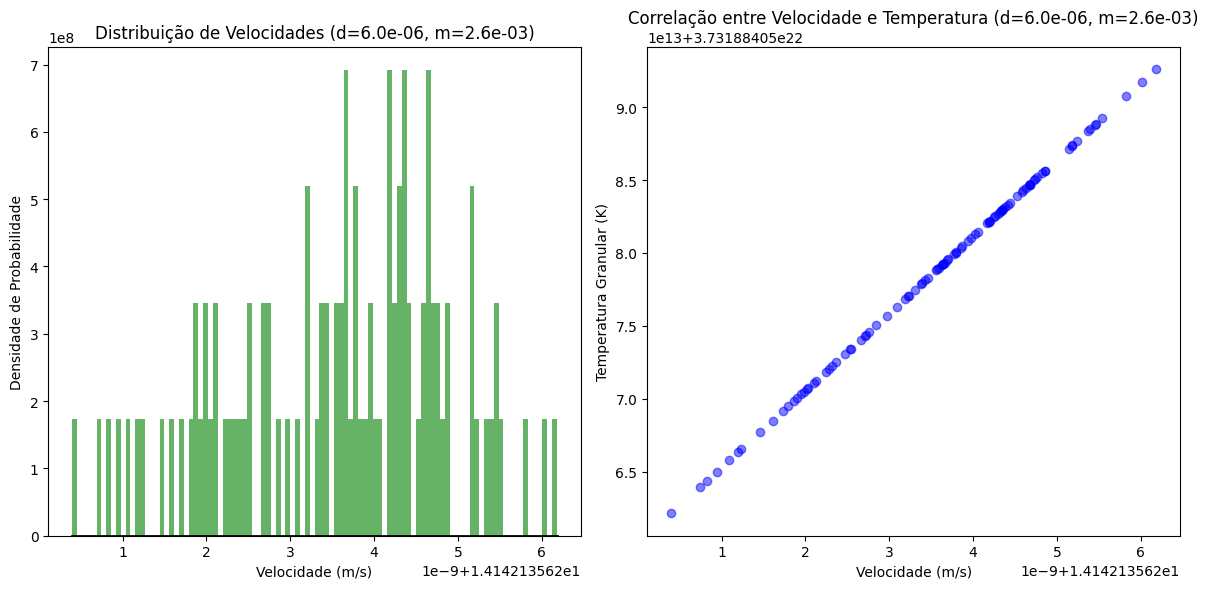

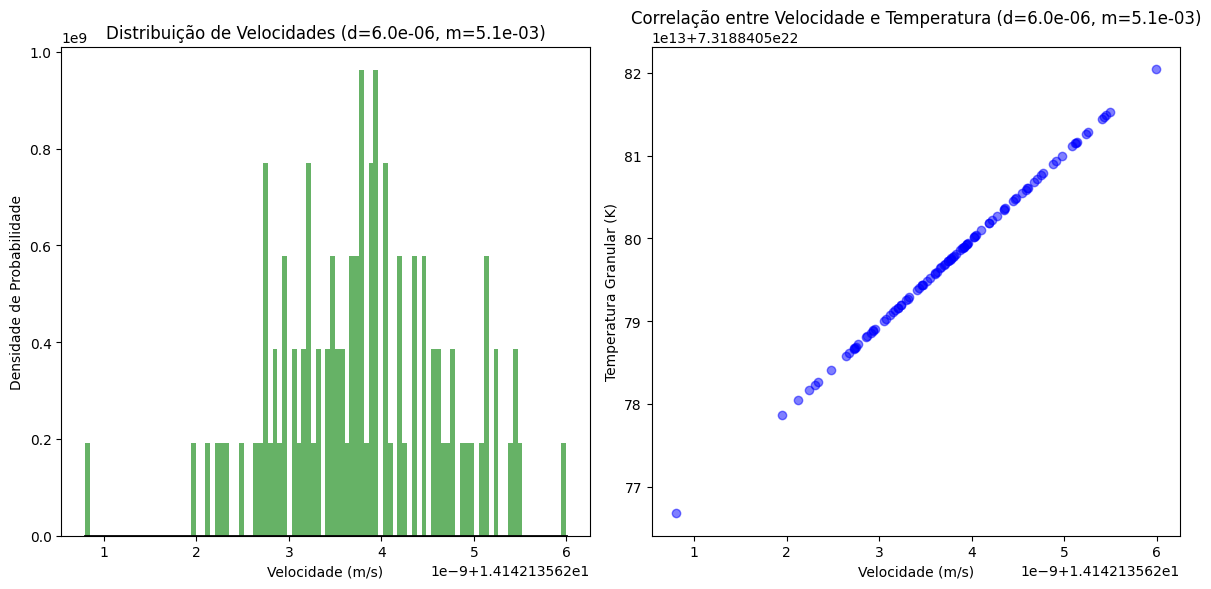

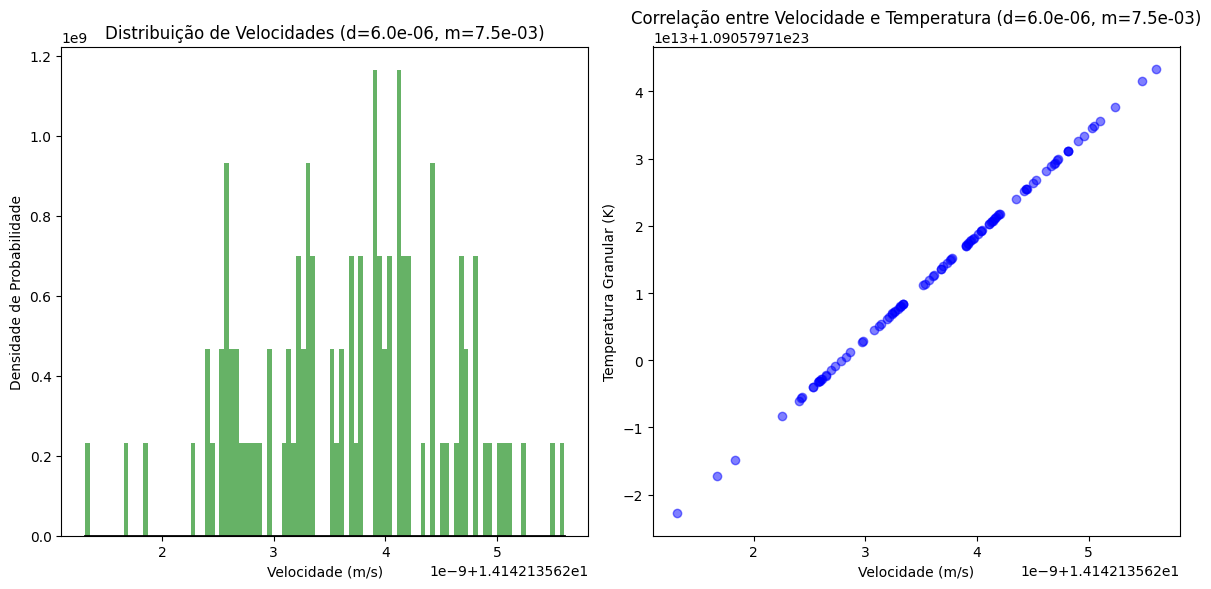

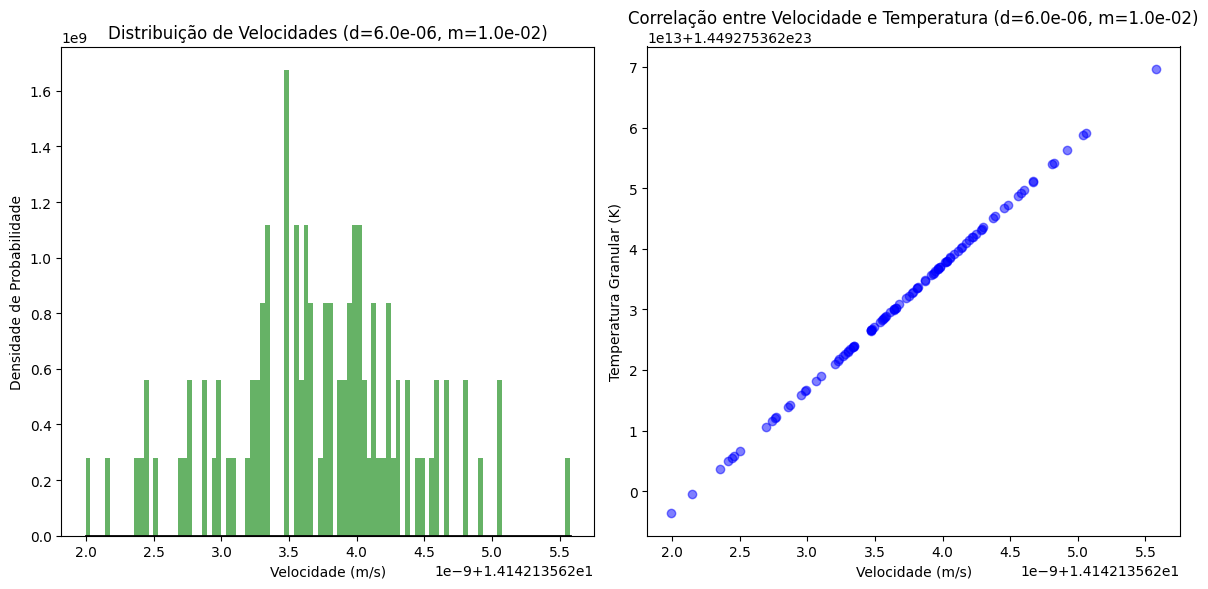

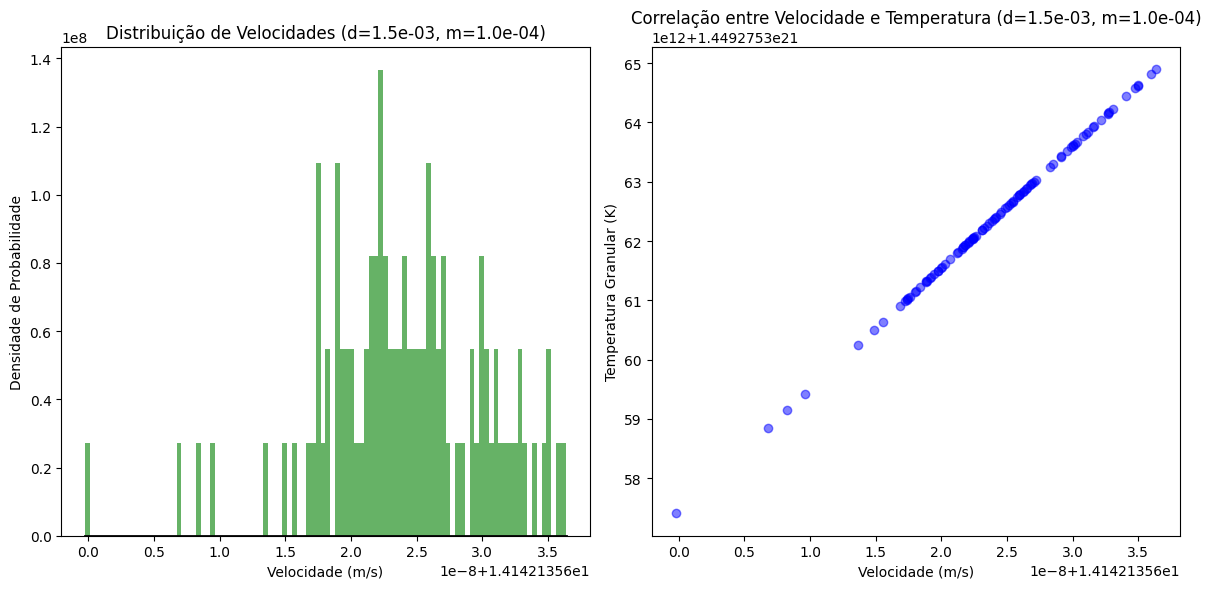

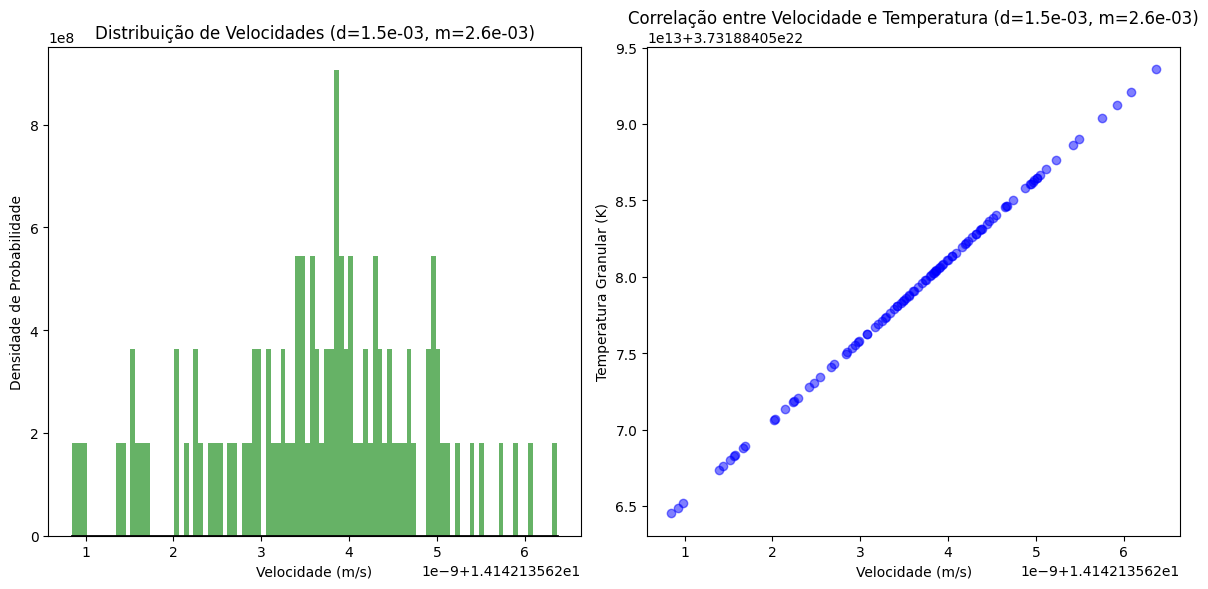

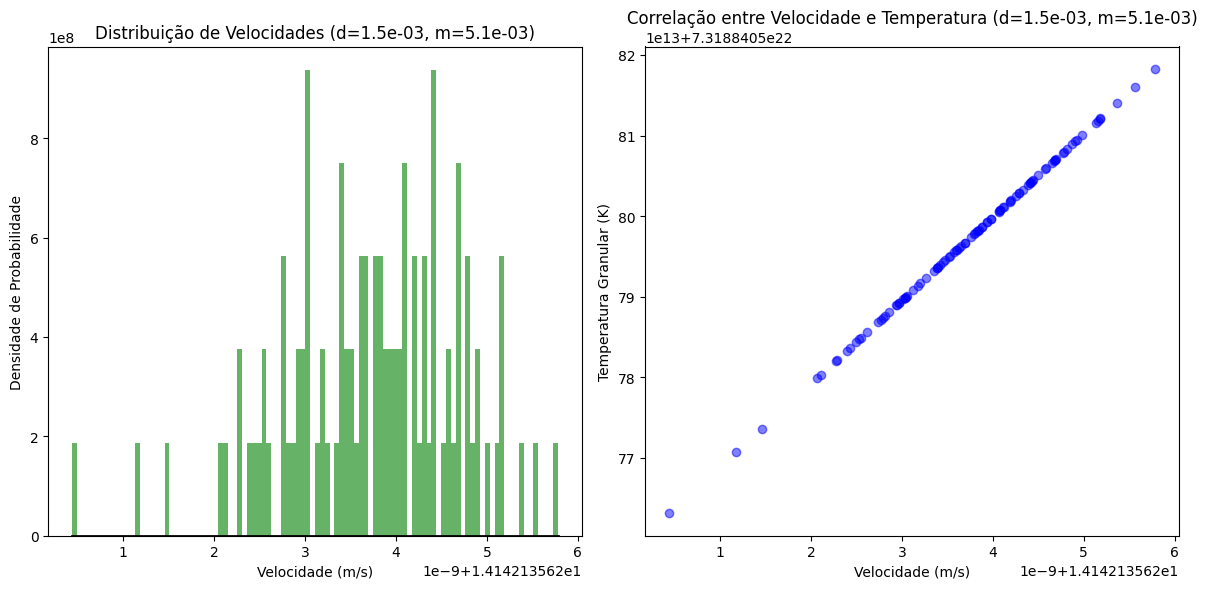

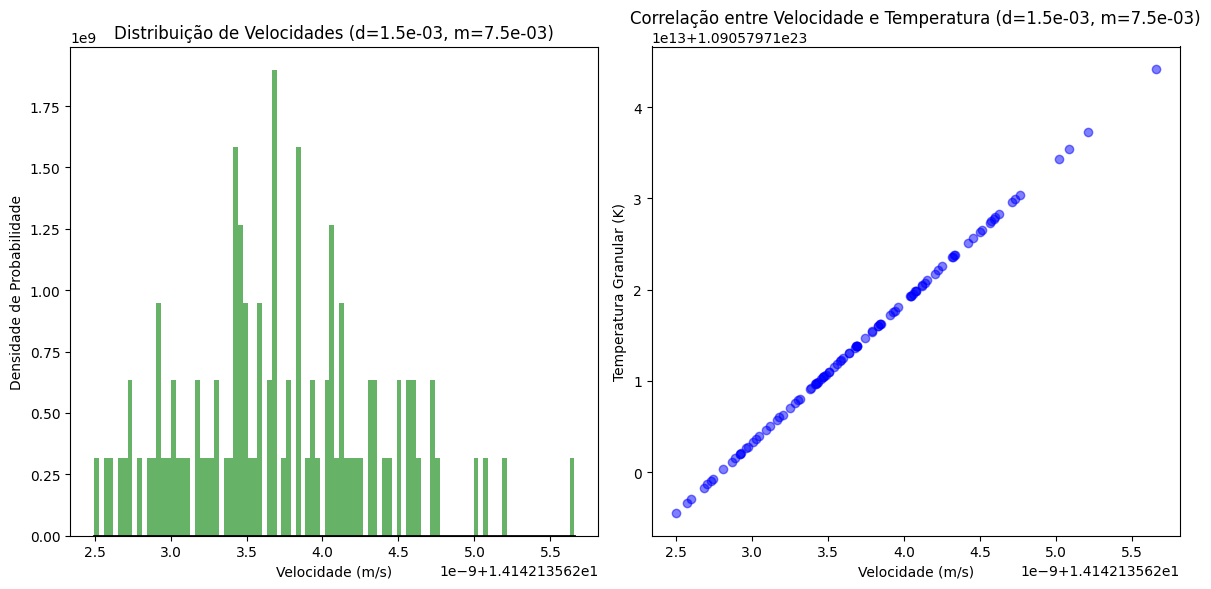

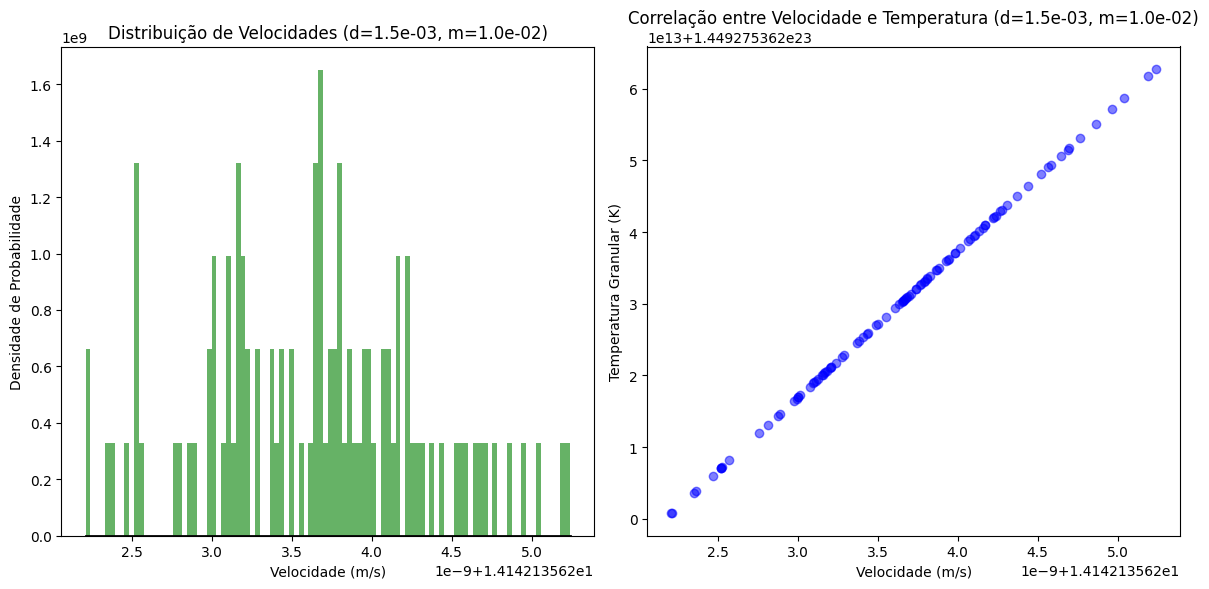

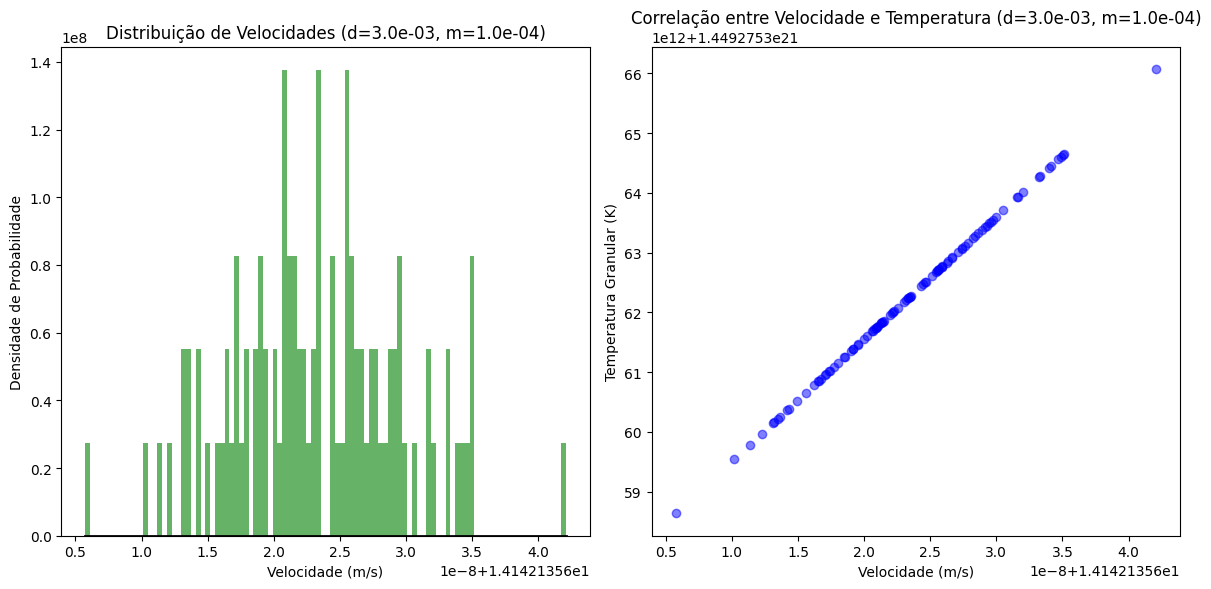

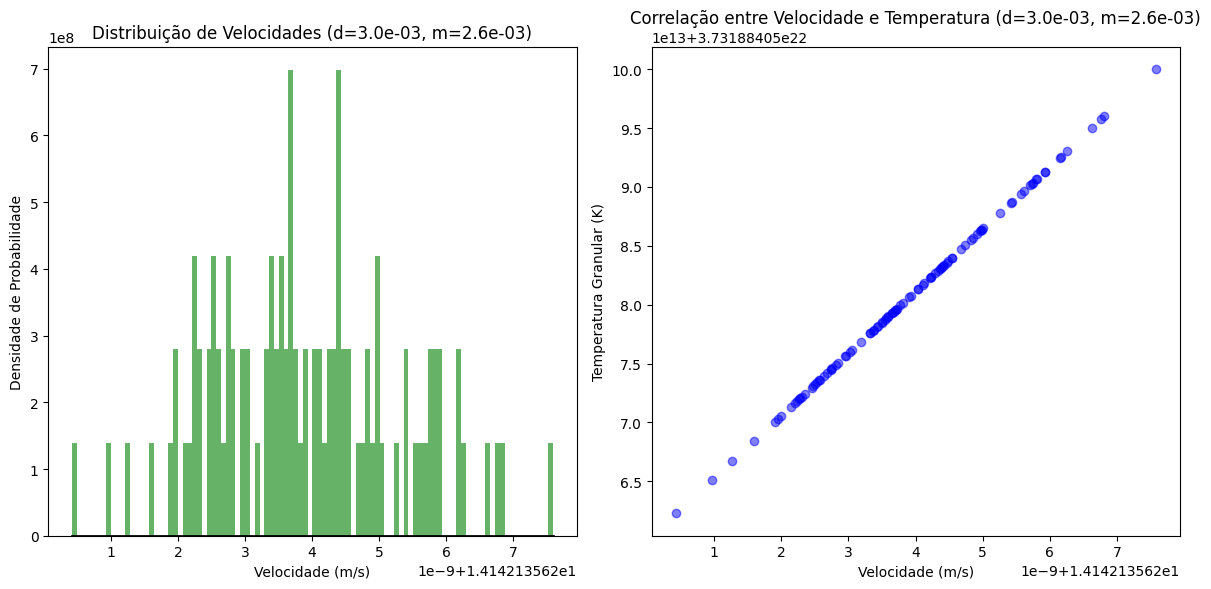

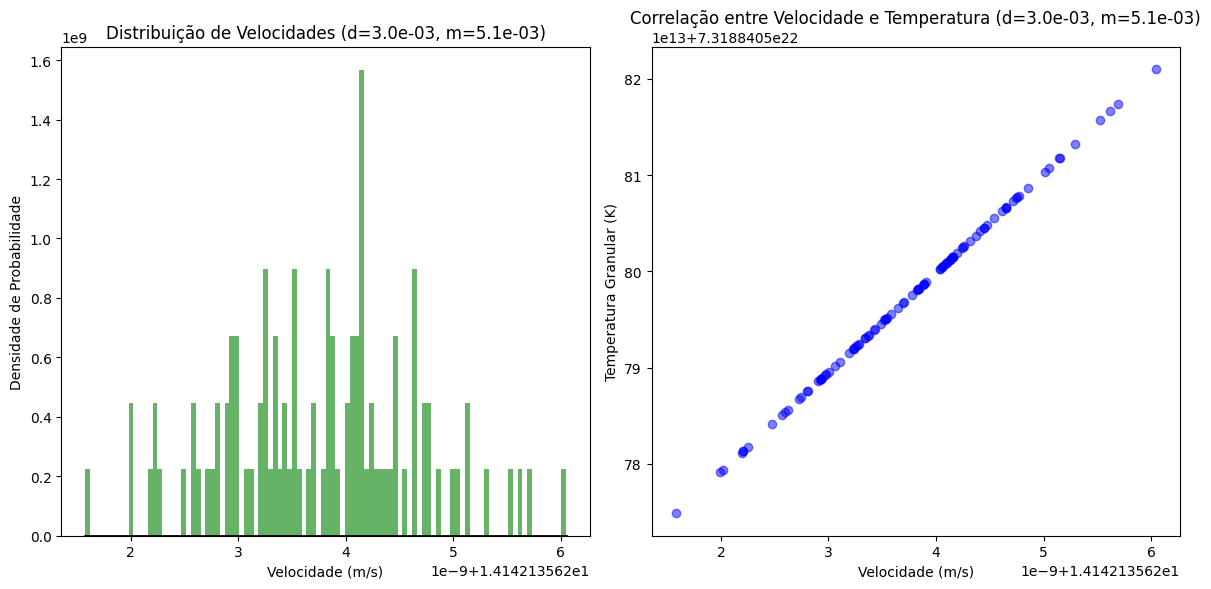

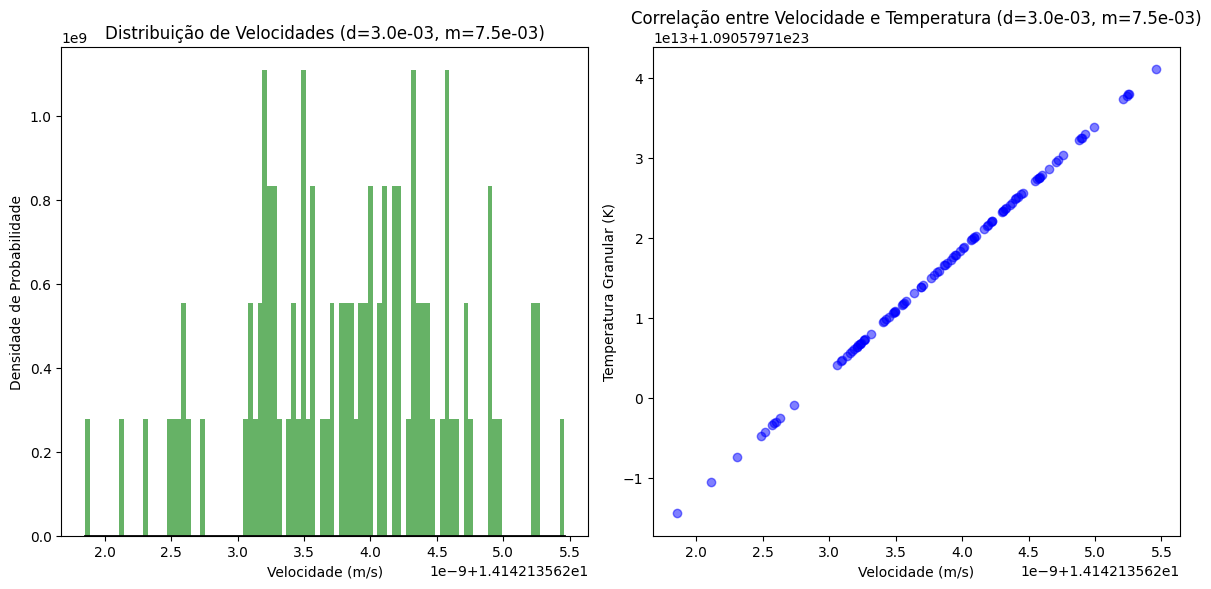

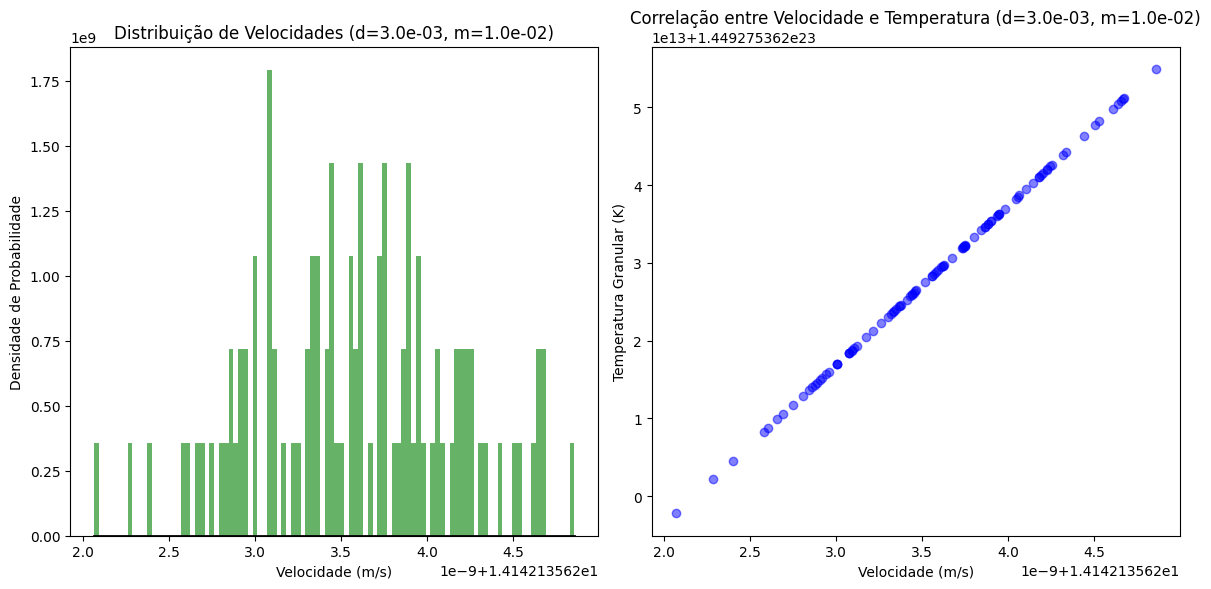

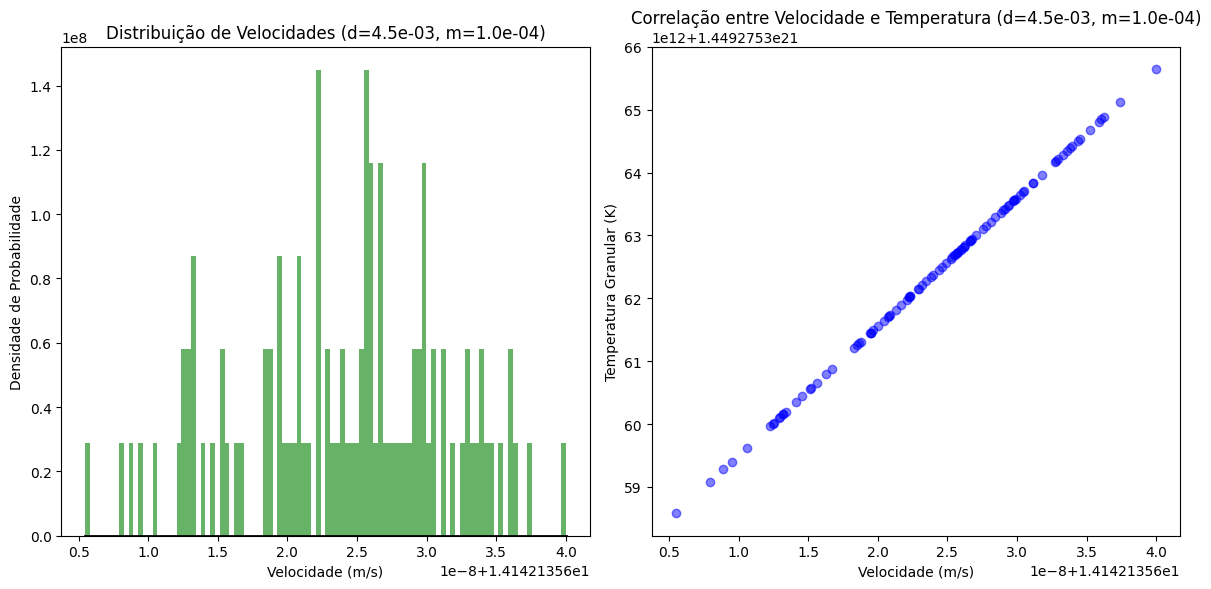

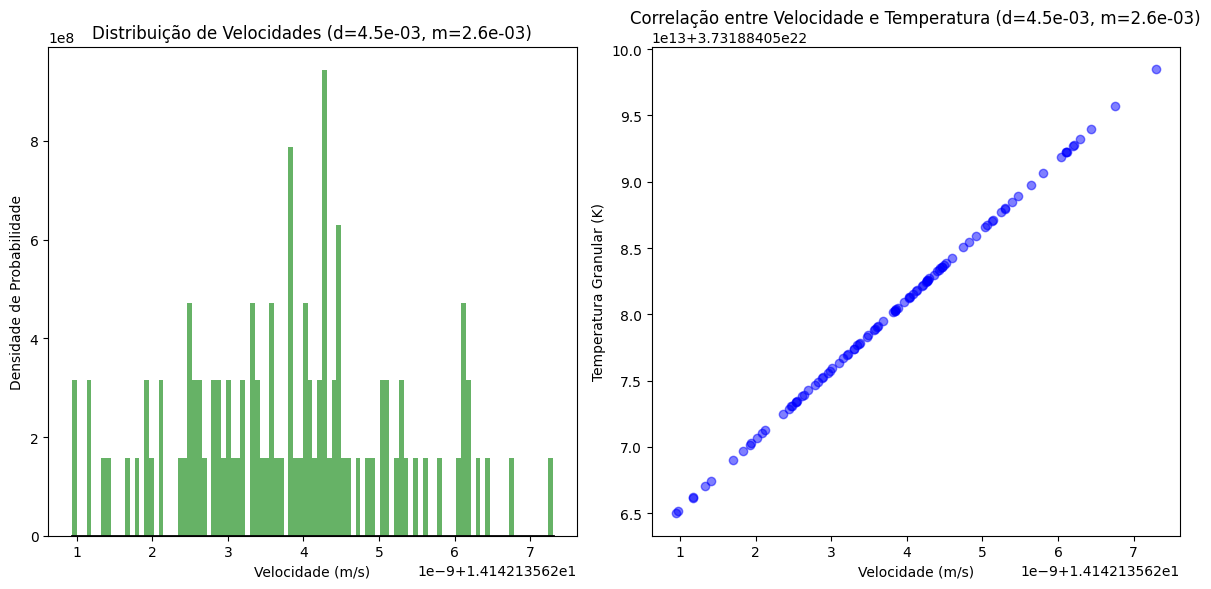

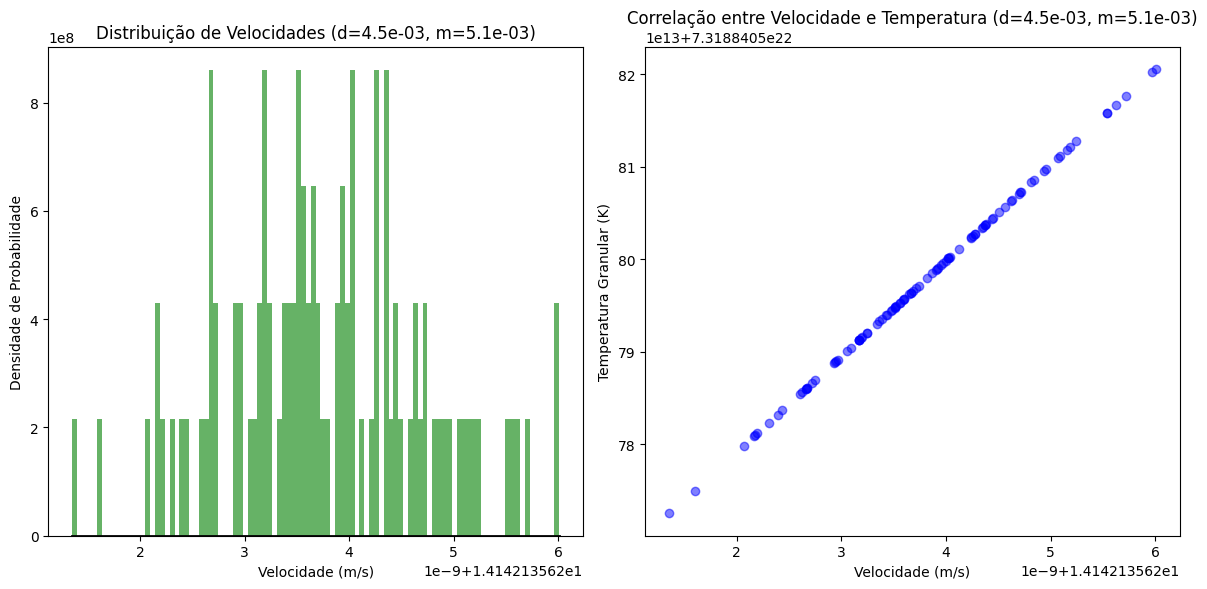

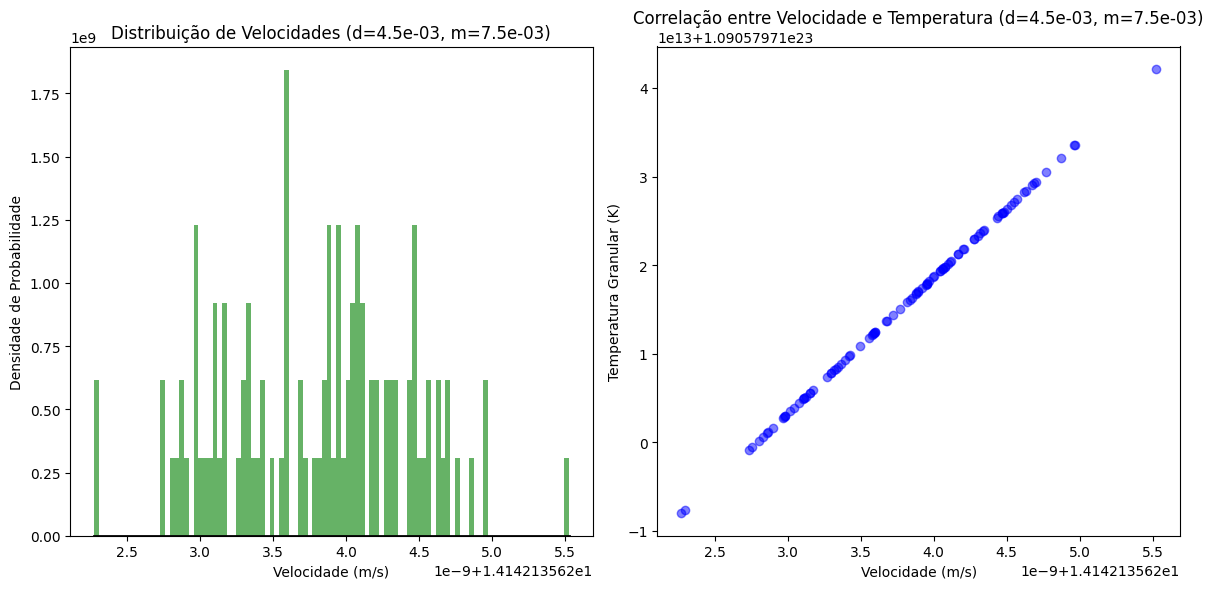

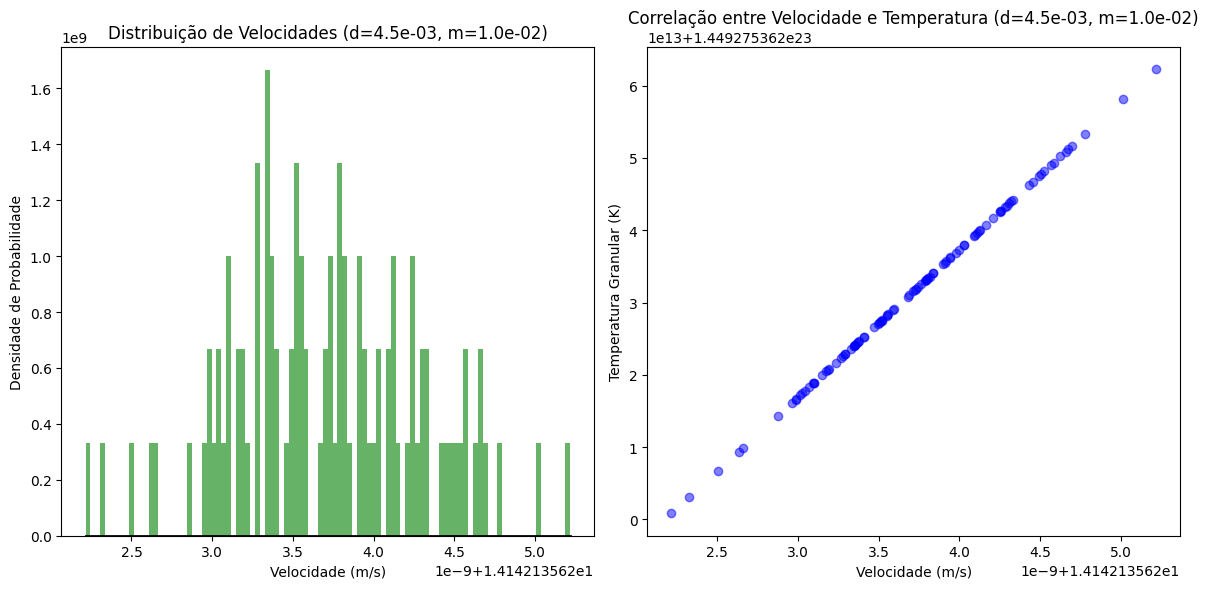

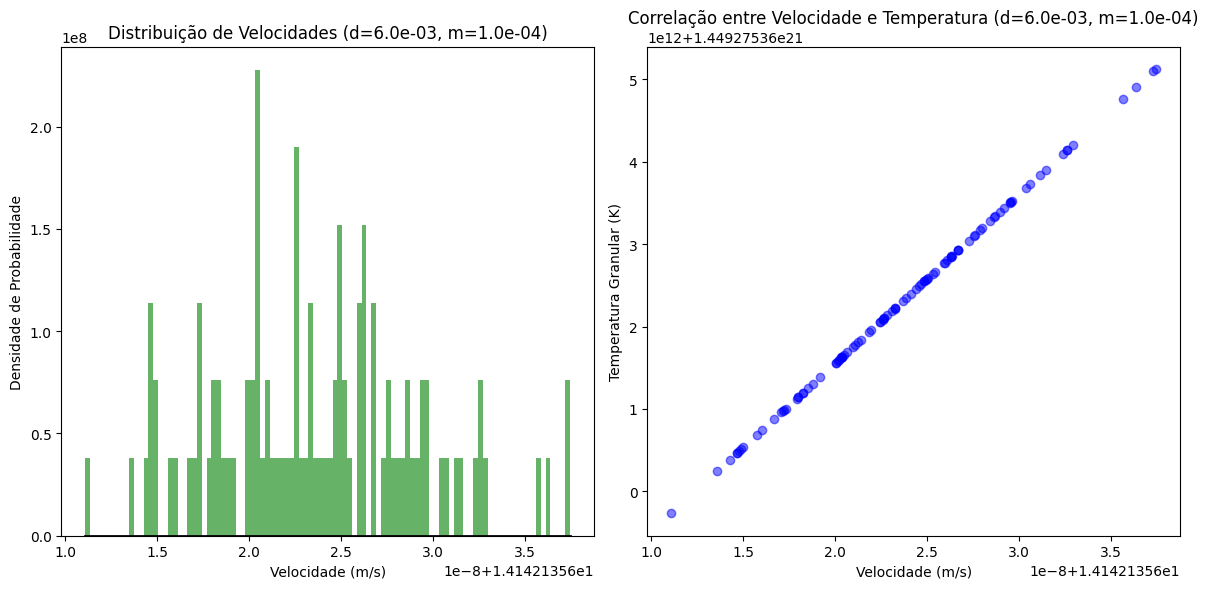

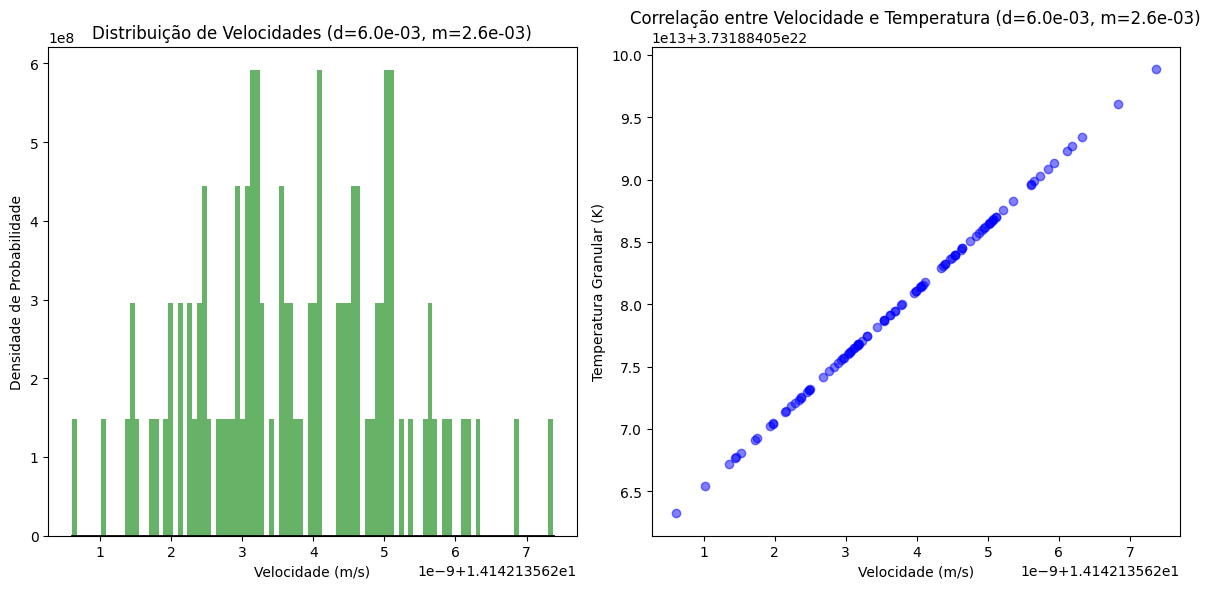

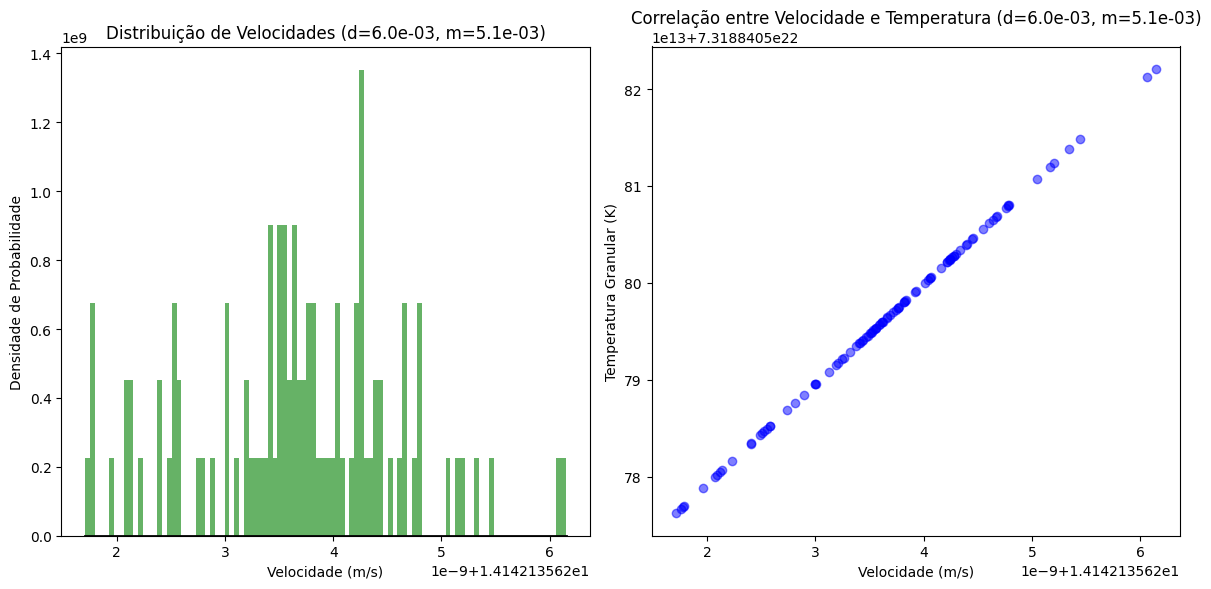

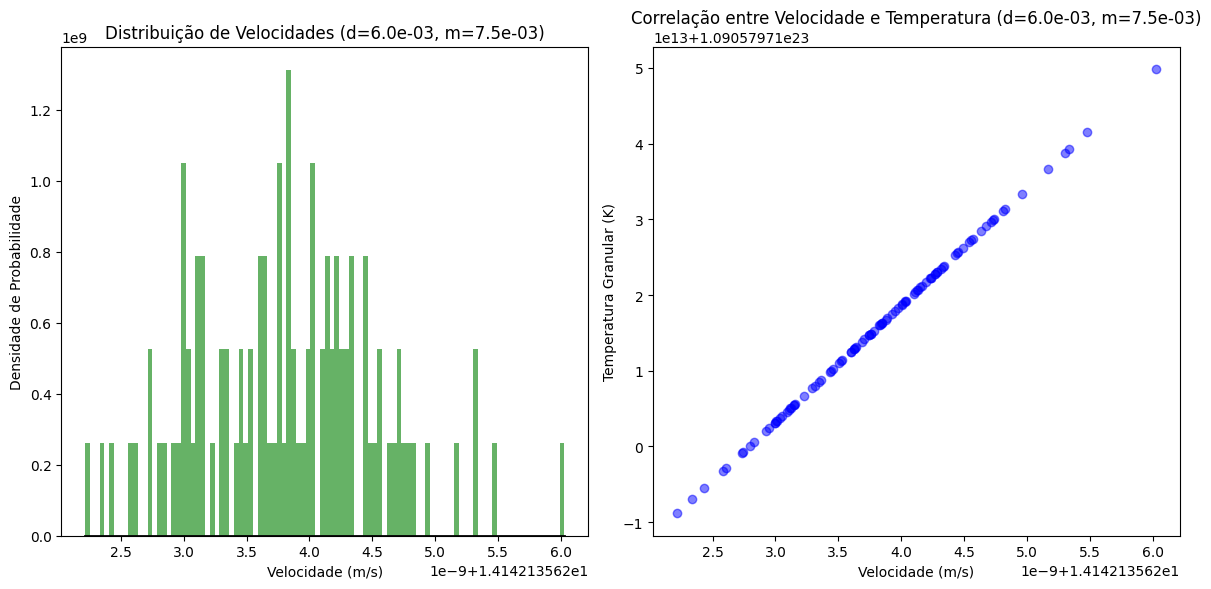

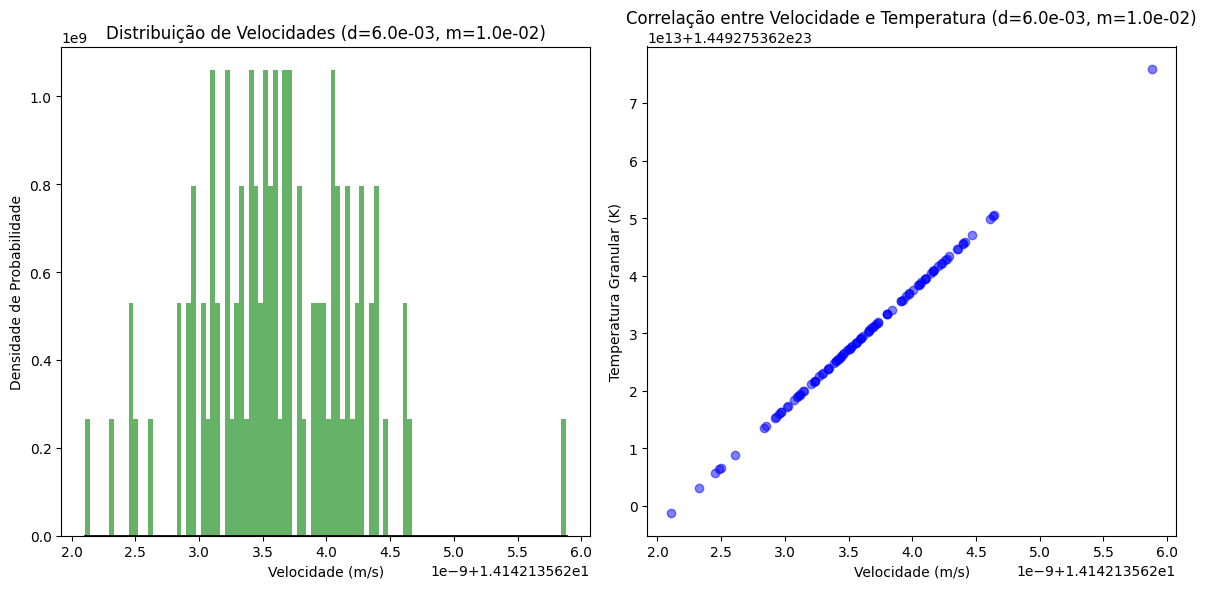

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros da simulação
N = 100  # Número de partículas
e = 0.9  # Coeficiente de restituição
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 10  # Velocidade inicial do fluxo (m/s)
timesteps = 100  # Número de passos de tempo
dt = 1e-3  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)

# Inicialização das partículas
def inicializar_particulas(N, T_g, m, v_flux):
    pos = np.random.rand(N, 2) * L  # Posições iniciais
    vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + v_flux  # Velocidades iniciais
    return pos, vel

# Definição da cunha (avião)
cunha_pos = [L / 2, L / 2]
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)

def checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle):
    # Verificar colisão e atualizar velocidade
    x, y = pos.T
    x_cunha, y_cunha = cunha_pos
    normal = np.array([np.cos(cunha_angle), np.sin(cunha_angle)])
    rel_pos = pos - cunha_pos
    dist = np.dot(rel_pos, normal)
    colisao = dist < 0
    vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt, d, e):
    for t in range(timesteps):
        # Atualizar posições
        pos += vel * dt

        # Verificar colisões com a cunha
        vel = checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle)

        # Verificar colisões entre partículas (simplificação)
        for i in range(N):
            for j in range(i + 1, N):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2

    return pos, vel

# Intervalos de variação
d_values = np.linspace(0.6e-5, 0.6e-2, 5)
m_values = np.linspace(0.0001, 0.01, 5)

for d in d_values:
    for m in m_values:
        # Inicializar partículas
        pos, vel = inicializar_particulas(N, T_g, m, v_flux)

        # Executar a simulação
        pos, vel = simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt, d, e)

        # Calcular propriedades macroscópicas
        T_g_calc = np.mean(np.linalg.norm(vel, axis=1)**2) * m / k_B
        rho = N / L**2
        P = rho * T_g_calc * (1 + e**2)

        # Geração de gráficos
        v_bins = np.linspace(np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), 100)
        pdf_v = (m / (2 * np.pi * k_B * T_g_calc))**1.5 * np.exp(-m * v_bins**2 / (2 * k_B * T_g_calc))

        plt.figure(figsize=(12, 6))

        # Distribuição de velocidades
        plt.subplot(1, 2, 1)
        plt.hist(np.linalg.norm(vel, axis=1), bins=100, density=True, alpha=0.6, color='g')
        plt.plot(v_bins, pdf_v, 'k-', lw=2)
        plt.title(f'Distribuição de Velocidades (d={d:.1e}, m={m:.1e})')
        plt.xlabel('Velocidade (m/s)')
        plt.ylabel('Densidade de Probabilidade')

        # Correlação entre velocidade e temperatura
        plt.subplot(1, 2, 2)
        plt.scatter(np.linalg.norm(vel, axis=1), np.linalg.norm(vel, axis=1)**2 * m / k_B, alpha=0.5, color='b')
        plt.title(f'Correlação entre Velocidade e Temperatura (d={d:.1e}, m={m:.1e})')
        plt.xlabel('Velocidade (m/s)')
        plt.ylabel('Temperatura Granular (K)')

        plt.tight_layout()
        plt.show()


In [ ]:
!pip install imageio


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Parâmetros da simulação
N = 1000  # Número de partículas
d = 0.6e-3  # Diâmetro das partículas (m)
e = 0.9  # Coeficiente de restituição
m = 0.001  # Massa das partículas (kg)
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 10  # Velocidade inicial do fluxo (m/s)
timesteps = 100  # Número de passos de tempo
dt = 1e-3  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)
frames = []  # Lista para armazenar os frames do GIF

# Inicialização das partículas
pos = np.random.rand(N, 2) * L  # Posições iniciais
vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + v_flux  # Velocidades iniciais

# Definição da cunha (avião)
cunha_pos = [L / 2, L / 2]
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)

def checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle):
    x, y = pos.T
    x_cunha, y_cunha = cunha_pos
    normal = np.array([np.cos(cunha_angle), np.sin(cunha_angle)])
    rel_pos = pos - cunha_pos
    dist = np.dot(rel_pos, normal)
    colisao = dist < 0
    vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt, d, e, frames):
    for t in range(timesteps):
        pos += vel * dt
        vel = checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle)
        for i in range(N):
            for j in range(i + 1, N):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2

        T_g_calc = np.mean(np.linalg.norm(vel, axis=1)**2) * m / k_B

        # Gráfico de gradiente de temperatura
        plt.figure(figsize=(6, 6))
        plt.hexbin(pos[:, 0], pos[:, 1], C=np.linalg.norm(vel, axis=1)**2 * m / k_B, gridsize=50, cmap='inferno')
        plt.colorbar(label='Temperatura Granular (K)')
        plt.title(f'Temperatura Granular - Passo de Tempo {t}')
        plt.xlim(0, L)
        plt.ylim(0, L)
        plt.xlabel('Posição X (m)')
        plt.ylabel('Posição Y (m)')

        # Salvar frame
        plt.savefig(f'frame_{t}.png')
        frames.append(f'frame_{t}.png')
        plt.close()

    return pos, vel

# Executar a simulação
pos, vel = simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt, d, e, frames)

# Criar GIF a partir dos frames
with imageio.get_writer('simulacao_temperatura.gif', mode='I', duration=0.1) as writer:
    for filename in frames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remover os frames temporários
import os
for filename in frames:
    os.remove(filename)

print("GIF criado com sucesso!")


<ipython-input-2-9f8a2def7d07>:73: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF criado com sucesso!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Parâmetros da simulação
N = 1000  # Número de partículas
d_values = np.linspace(0.6e-5, 0.6e-2, 5)  # Variação do diâmetro das partículas (m)
m_values = np.linspace(0.0001, 0.01, 5)  # Variação da massa das partículas (kg)
e = 0.9  # Coeficiente de restituição
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 10  # Velocidade inicial do fluxo (m/s)
timesteps = 10  # Número de passos de tempo
dt = 1e-3  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)
frames = []  # Lista para armazenar os frames do GIF

# Inicialização das partículas
def init_particles(N, L, T_g, m, k_B, v_flux):
    pos = np.random.rand(N, 2) * L  # Posições iniciais
    vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + v_flux  # Velocidades iniciais
    return pos, vel

# Definição da cunha (avião)
cunha_pos = np.array([L / 2, L / 2])
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)
cunha_size = 0.2  # Tamanho da cunha

def checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle, cunha_size):
    x, y = pos.T
    x_cunha, y_cunha = cunha_pos
    normal = np.array([np.cos(cunha_angle), np.sin(cunha_angle)])
    rel_pos = pos - cunha_pos
    dist = np.dot(rel_pos, normal)
    colisao = (dist < 0) & (np.abs(rel_pos[:, 0] * np.tan(cunha_angle)) < cunha_size)
    vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def simular(N, pos, vel, cunha_pos, cunha_angle, cunha_size, timesteps, dt, d, e, frames):
    for t in range(timesteps):
        pos += vel * dt
        vel = checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle, cunha_size)
        for i in range(N):
            for j in range(i + 1, N):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2

        T_g_calc = np.mean(np.linalg.norm(vel, axis=1)**2) * m / k_B

        # Gráfico de gradiente de temperatura
        plt.figure(figsize=(18, 6))

        # Plot 1: Gradiente de temperatura
        plt.subplot(1, 3, 1)
        plt.hexbin(pos[:, 0], pos[:, 1], C=np.linalg.norm(vel, axis=1)**2 * m / k_B, gridsize=50, cmap='inferno')
        plt.colorbar(label='Temperatura Granular (K)')
        plt.title(f'Temperatura Granular - Passo de Tempo {t}')
        plt.xlim(0, L)
        plt.ylim(0, L)
        plt.xlabel('Posição X (m)')
        plt.ylabel('Posição Y (m)')

        # Plot 2: Distribuição de velocidades
        plt.subplot(1, 3, 2)
        v_bins = np.linspace(np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), 100)
        pdf_v = (m / (2 * np.pi * k_B * T_g_calc))**1.5 * np.exp(-m * v_bins**2 / (2 * k_B * T_g_calc))
        plt.hist(np.linalg.norm(vel, axis=1), bins=100, density=True, alpha=0.6, color='g')
        plt.plot(v_bins, pdf_v, 'k-', lw=2)
        plt.title('Distribuição de Velocidades')
        plt.xlabel('Velocidade (m/s)')
        plt.ylabel('Densidade de Probabilidade')

        # Plot 3: Colisões
        plt.subplot(1, 3, 3)
        plt.scatter(np.linalg.norm(vel, axis=1), np.linalg.norm(vel, axis=1)**2 * m / k_B, alpha=0.5, color='b')
        plt.title('Correlação entre Velocidade e Temperatura')
        plt.xlabel('Velocidade (m/s)')
        plt.ylabel('Temperatura Granular (K)')

        plt.tight_layout()
        # Salvar frame
        plt.savefig(f'frame_{t}.png')
        frames.append(f'frame_{t}.png')
        plt.close()

    return pos, vel

# Executar a simulação para diferentes valores de d e m
for d in d_values:
    for m in m_values:
        pos, vel = init_particles(N, L, T_g, m, k_B, v_flux)
        simular(N, pos, vel, cunha_pos, cunha_angle, cunha_size, timesteps, dt, d, e, frames)

# Criar GIF a partir dos frames
with imageio.get_writer('simulacao_temperatura.gif', mode='I', duration=0.1) as writer:
    for filename in frames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remover os frames temporários
for filename in frames:
    os.remove(filename)

print("GIF criado com sucesso!")


<ipython-input-1-162c6429e8cd>:101: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


FileNotFoundError: [Errno 2] No such file or directory: 'frame_0.png'

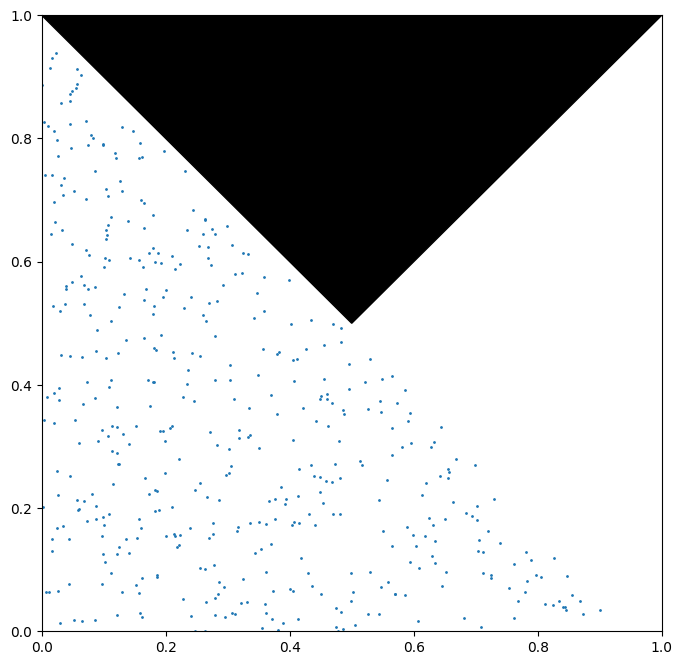

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parâmetros da simulação
N = 1000  # Número de partículas
d = 0.6e-3  # Diâmetro das partículas (m)
e = 0.9  # Coeficiente de restituição
m = 0.001  # Massa das partículas (kg)
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 10  # Velocidade inicial do fluxo (m/s)
timesteps = 500  # Número de passos de tempo
dt = 1e-3  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)

# Inicialização das partículas
pos = np.random.rand(N, 2) * L  # Posições iniciais
vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + v_flux  # Velocidades iniciais

# Definição da cunha (triangular)
cunha_pos = [L / 2, L / 2]
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)

def checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle):
    x, y = pos.T
    x_cunha, y_cunha = cunha_pos
    normal = np.array([np.cos(cunha_angle), np.sin(cunha_angle)])
    rel_pos = pos - cunha_pos
    dist = np.dot(rel_pos, normal)
    colisao = dist < 0
    vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt):
    posicoes = []
    for t in range(timesteps):
        pos += vel * dt
        vel = checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle)
        for i in range(N):
            for j in range(i+1, N):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2
        posicoes.append(pos.copy())
    return posicoes, vel

posicoes, vel = simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt)

# Criação do GIF
fig, ax = plt.subplots(figsize=(8, 8))
cunha = plt.Polygon([[0.5, 0.5], [0, 1], [1, 1]], closed=True, color='black')
ax.add_patch(cunha)

def update(frame):
    ax.clear()
    ax.add_patch(cunha)
    ax.scatter(posicoes[frame][:, 0], posicoes[frame][:, 1], s=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    return ax

ani = animation.FuncAnimation(fig, update, frames=timesteps, interval=30)
ani.save('simulacao_particulas.gif', writer='imagemagick')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parâmetros da simulação
N = 1000  # Número de partículas
d = 0.6e-3  # Diâmetro das partículas (m)
e = 0.9  # Coeficiente de restituição
m = 0.001  # Massa das partículas (kg)
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 10  # Velocidade inicial do fluxo (m/s)
timesteps = 500  # Número de passos de tempo
dt = 1e-3  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)

# Inicialização das partículas
pos = np.random.rand(N, 2) * L  # Posições iniciais
vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + v_flux  # Velocidades iniciais

# Definição da cunha (triangular)
cunha_pos = [L / 2, L / 2]
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)

def checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle):
    x, y = pos.T
    x_cunha, y_cunha = cunha_pos
    normal = np.array([np.cos(cunha_angle), np.sin(cunha_angle)])
    rel_pos = pos - cunha_pos
    dist = np.dot(rel_pos, normal)
    colisao = dist < 0
    vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt):
    posicoes = []
    temperaturas = []
    for t in range(timesteps):
        pos += vel * dt
        vel = checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle)
        for i in range(N):
            for j in range(i+1, N):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2
        posicoes.append(pos.copy())
        T_g_calc = np.mean(np.linalg.norm(vel, axis=1)**2) * m / k_B
        temperaturas.append(T_g_calc)
    return posicoes, vel, temperaturas

posicoes, vel, temperaturas = simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt)

# Criação do GIF da simulação de partículas
fig, ax = plt.subplots(figsize=(8, 8))
cunha = plt.Polygon([[0.5, 0.5], [0, 1], [1, 1]], closed=True, color='black')
ax.add_patch(cunha)

def update_particles(frame):
    ax.clear()
    ax.add_patch(cunha)
    ax.scatter(posicoes[frame][:, 0], posicoes[frame][:, 1], s=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    return ax

ani_particles = animation.FuncAnimation(fig, update_particles, frames=timesteps, interval=30)
ani_particles.save('simulacao_particulas.gif', writer='imagemagick')

# Criação do GIF da distribuição de velocidades
fig, ax = plt.subplots(figsize=(8, 6))

def update_vel(frame):
    ax.clear()
    v_bins = np.linspace(np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), 100)
    pdf_v = (m / (2 * np.pi * k_B * temperaturas[frame]))**1.5 * np.exp(-m * v_bins**2 / (2 * k_B * temperaturas[frame]))
    ax.hist(np.linalg.norm(vel, axis=1), bins=100, density=True, alpha=0.6, color='g')
    ax.plot(v_bins, pdf_v, 'k-', lw=2)
    ax.set_title('Distribuição de Velocidades')
    ax.set_xlabel('Velocidade (m/s)')
    ax.set_ylabel('Densidade de Probabilidade')
    return ax

ani_vel = animation.FuncAnimation(fig, update_vel, frames=timesteps, interval=30)
ani_vel.save('distribuicao_velocidades.gif', writer='imagemagick')

# Criação do GIF do gradiente de temperatura
fig, ax = plt.subplots(figsize=(8, 6))

def update_temp(frame):
    ax.clear()
    T_bins = np.linspace(np.min(temperaturas), np.max(temperaturas), 100)
    pdf_T = (2 * np.pi * k_B * T_bins / m)**-1.5 * np.exp(-k_B * T_bins / (2 * m))
    ax.hist(temperaturas, bins=100, density=True, alpha=0.6, color='r')
    ax.plot(T_bins, pdf_T, 'k-', lw=2)
    ax.set_title('Gradiente de Temperatura')
    ax.set_xlabel('Temperatura (K)')
    ax.set_ylabel('Densidade de Probabilidade')
    return ax

ani_temp = animation.FuncAnimation(fig, update_temp, frames=timesteps, interval=30)
ani_temp.save('gradiente_temperatura.gif', writer='imagemagick')

plt.show()


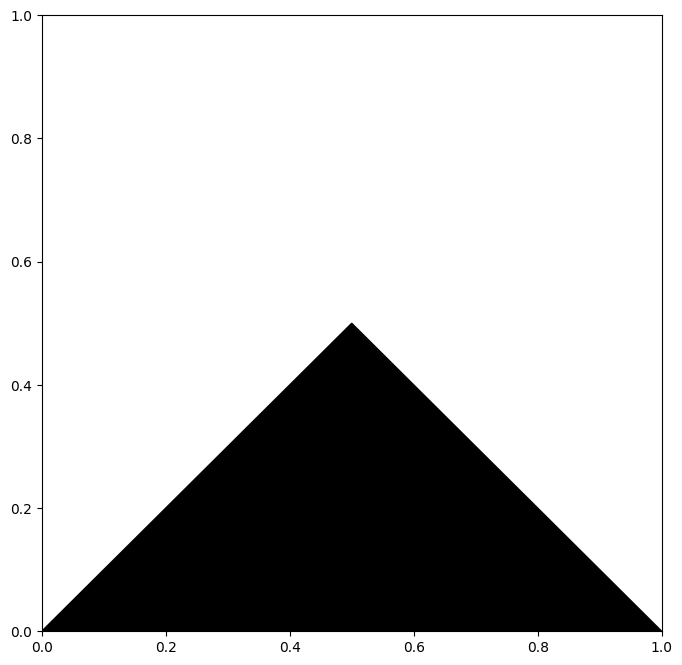

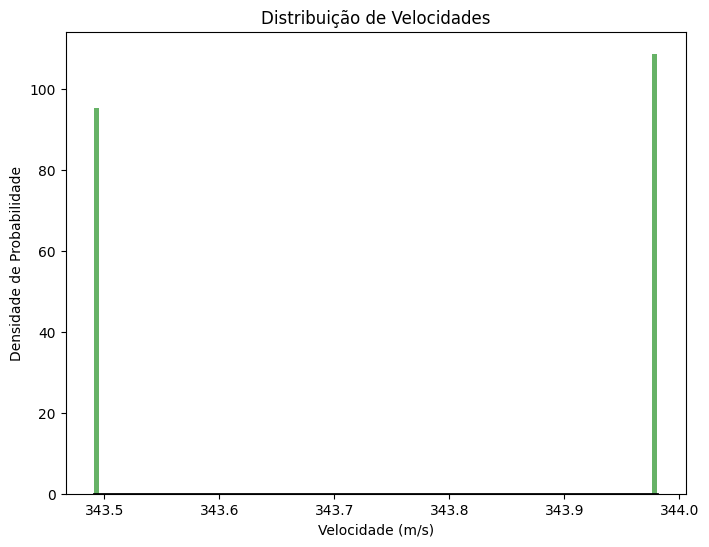

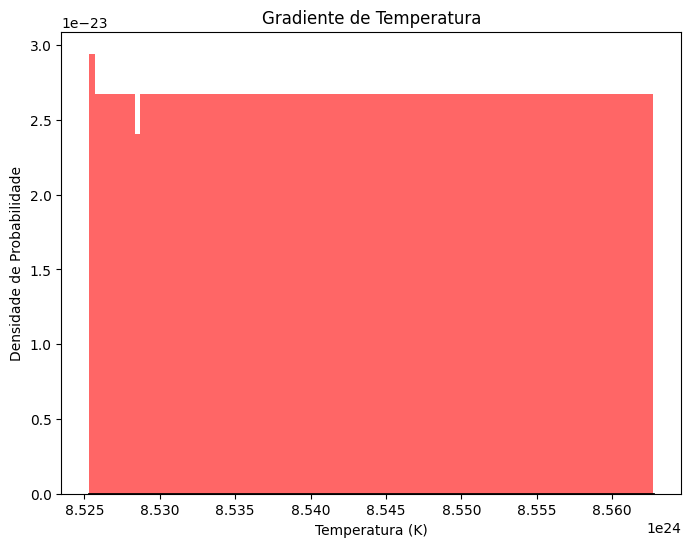

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parâmetros da simulação
N = 1000  # Número de partículas
d = 0.6e-3  # Diâmetro das partículas (m)
e = 0.9  # Coeficiente de restituição
m = 0.001  # Massa das partículas (kg)
k_B = 1.38e-23  # Constante de Boltzmann (J/K)
T_g = 300  # Temperatura inicial granular (K)
v_flux = 343  # Velocidade inicial do fluxo (Mach 1 ~ 343 m/s)
timesteps = 1000  # Número de passos de tempo
dt = 1e-4  # Intervalo de tempo (s)
L = 1  # Comprimento do domínio (m)
g = 9.81  # Aceleração gravitacional (m/s^2)

# Inicialização das partículas
pos = np.random.rand(N, 2) * L  # Posições iniciais
vel = np.random.normal(0, np.sqrt(k_B * T_g / m), (N, 2)) + np.array([0, -v_flux])  # Velocidades iniciais

# Definição da cunha (triangular) invertida
cunha_pos = [L / 2, L / 2]
cunha_angle = np.pi / 4  # Ângulo da cunha (45 graus)

def checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle):
    x, y = pos.T
    x_cunha, y_cunha = cunha_pos
    normal = np.array([np.cos(cunha_angle), -np.sin(cunha_angle)])  # Cunha invertida
    rel_pos = pos - cunha_pos
    dist = np.dot(rel_pos, normal)
    colisao = dist < 0
    vel[colisao] = vel[colisao] - 2 * np.dot(vel[colisao], normal)[:, np.newaxis] * normal
    return vel

def simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt):
    posicoes = []
    temperaturas = []
    for t in range(timesteps):
        vel[:, 1] -= g * dt  # Adiciona gravidade
        pos += vel * dt
        vel = checar_colisao_cunha(pos, vel, cunha_pos, cunha_angle)
        for i in range(N):
            for j in range(i + 1, N):
                if np.linalg.norm(pos[i] - pos[j]) < d:
                    v_i = vel[i]
                    v_j = vel[j]
                    vel[i] = (v_i + v_j) / 2 + e * (v_i - v_j) / 2
                    vel[j] = (v_i + v_j) / 2 - e * (v_i - v_j) / 2
        posicoes.append(pos.copy())
        T_g_calc = np.mean(np.linalg.norm(vel, axis=1) ** 2) * m / k_B
        temperaturas.append(T_g_calc)
    return posicoes, vel, temperaturas

posicoes, vel, temperaturas = simular(N, pos, vel, cunha_pos, cunha_angle, timesteps, dt)

# Criação do GIF da simulação de partículas
fig, ax = plt.subplots(figsize=(8, 8))
cunha = plt.Polygon([[0.5, 0.5], [0, 0], [1, 0]], closed=True, color='black')
ax.add_patch(cunha)

def update_particles(frame):
    ax.clear()
    ax.add_patch(cunha)
    ax.scatter(posicoes[frame][:, 0], posicoes[frame][:, 1], s=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    return ax

ani_particles = animation.FuncAnimation(fig, update_particles, frames=timesteps, interval=30)
ani_particles.save('simulacao_particulas.gif', writer='imagemagick')

# Criação do GIF da distribuição de velocidades
fig, ax = plt.subplots(figsize=(8, 6))

def update_vel(frame):
    ax.clear()
    v_bins = np.linspace(np.min(np.linalg.norm(vel, axis=1)), np.max(np.linalg.norm(vel, axis=1)), 100)
    pdf_v = (m / (2 * np.pi * k_B * temperaturas[frame])) ** 1.5 * np.exp(-m * v_bins ** 2 / (2 * k_B * temperaturas[frame]))
    ax.hist(np.linalg.norm(vel, axis=1), bins=100, density=True, alpha=0.6, color='g')
    ax.plot(v_bins, pdf_v, 'k-', lw=2)
    ax.set_title('Distribuição de Velocidades')
    ax.set_xlabel('Velocidade (m/s)')
    ax.set_ylabel('Densidade de Probabilidade')
    return ax

ani_vel = animation.FuncAnimation(fig, update_vel, frames=timesteps, interval=30)
ani_vel.save('distribuicao_velocidades.gif', writer='imagemagick')

# Criação do GIF do gradiente de temperatura
fig, ax = plt.subplots(figsize=(8, 6))

def update_temp(frame):
    ax.clear()
    T_bins = np.linspace(np.min(temperaturas), np.max(temperaturas), 100)
    pdf_T = (2 * np.pi * k_B * T_bins / m) ** -1.5 * np.exp(-k_B * T_bins / (2 * m))
    ax.hist(temperaturas, bins=100, density=True, alpha=0.6, color='r')
    ax.plot(T_bins, pdf_T, 'k-', lw=2)
    ax.set_title('Gradiente de Temperatura')
    ax.set_xlabel('Temperatura (K)')
    ax.set_ylabel('Densidade de Probabilidade')
    return ax

ani_temp = animation.FuncAnimation(fig, update_temp, frames=timesteps, interval=30)
ani_temp.save('gradiente_temperatura.gif', writer='imagemagick')

plt.show()
